In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip -qq '/content/gdrive/MyDrive/accidents @dl.zip' -d /content/mani

In [3]:
!pip -qq install transformers

from transformers import pipeline

In [4]:
pip -qq install transformers huggingface_hub pillow

In [5]:
from huggingface_hub import list_models
modellist=[]
for model in list_models(limit=200, sort="downloads", direction=-1, filter="zero-shot-image-classification"):
    #print(model.id, model.downloads)
    modellist.append(model.id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
modellist

['openai/clip-vit-large-patch14',
 'openai/clip-vit-base-patch32',
 'google/siglip-so400m-patch14-384',
 'openai/clip-vit-large-patch14-336',
 'openai/clip-vit-base-patch16',
 'patrickjohncyh/fashion-clip',
 'laion/CLIP-ViT-H-14-laion2B-s32B-b79K',
 'HuggingFaceM4/siglip-so400m-14-384',
 'laion/CLIP-ViT-B-32-laion2B-s34B-b79K',
 'laion/CLIP-ViT-B-16-laion2B-s34B-b88K',
 'google/siglip2-so400m-patch14-384',
 'laion/CLIP-convnext_base_w-laion2B-s13B-b82K-augreg',
 'yuvalkirstain/PickScore_v1',
 'Marqo/marqo-fashionSigLIP',
 'StanfordAIMI/XrayCLIP__vit-b-16__laion2b-s34b-b88k',
 'timm/ViT-SO400M-14-SigLIP-384',
 'laion/CLIP-ViT-bigG-14-laion2B-39B-b160k',
 'google/siglip-base-patch16-224',
 'apple/MobileCLIP-S2-OpenCLIP',
 'laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',
 'google/siglip-large-patch16-384',
 'laion/CLIP-convnext_large_d_320.laion2B-s29B-b131K-ft-soup',
 'timm/ViT-B-16-SigLIP-i18n-256',
 'facebook/metaclip-b16-fullcc2.5b',
 'kakaobrain/align-base',
 'OFA-Sys/chinese-clip-vit-ba

In [7]:
import os
entries=os.listdir("/content/mani")

In [8]:
import os

# Path to the dataset directory
dataset_path = "/content/mani/accidents @dl"

# List all entries in the directory
entries = os.listdir(dataset_path)

# Filter out only the directories (classes)
classes = [entry for entry in entries if os.path.isdir(os.path.join(dataset_path, entry))]

# Print the classes
print("Classes in the dataset:", classes)

Classes in the dataset: ['Accident', 'Non Accident']


In [9]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.cuda.amp import autocast

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model name (you can change this to any CLIP model from Hugging Face)
model_name = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"

# Define possible labels (Zero-shot classes)
labels = ["accident", "non accident"]

# Change the current working directory to where the images are stored
os.chdir("/content/mani/accidents @dl/Accident")

# Load model and processor
try:
    model = CLIPModel.from_pretrained(model_name).to(device)
    processor = CLIPProcessor.from_pretrained(model_name)
    print(f"Successfully loaded model: {model_name}")
except Exception as e:
    print(f"Error loading model {model_name}: {e}")
    exit()

# Initialize counters
accident_count = 0
total_images = 0
correct_predictions = 0

# Process images
def process_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(text=labels, images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad(), autocast(enabled=device.type == 'cuda'):
            outputs = model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)

        predicted_label = labels[probs.argmax().item()]
        confidence = probs.max().item()
        return predicted_label, confidence
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

# Get list of image files
image_files = [f for f in os.listdir(".") if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
print(f"Found {len(image_files)} image files")

# Process each image
for image_file in image_files:
    total_images += 1
    true_label = "accident"  # Assuming all images are accident-related

    predicted_label, confidence = process_image(image_file)

    if predicted_label:
        if predicted_label == "accident":
            accident_count += 1
        if predicted_label == true_label:
            correct_predictions += 1

# Calculate and print results
if total_images > 0:
    accuracy = (correct_predictions / total_images) * 100
    print(f"\nResults for model: {model_name}")
    print(f"Total images processed: {total_images}")
    print(f"Accident predictions: {accident_count}")
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("No images found in the directory")
    #save model
    torch.save(model.state_dict(), f"laion/CLIP-ViT-L-14-laion2B-s32B-b82K.pth")


Using device: cuda


config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Successfully loaded model: laion/CLIP-ViT-L-14-laion2B-s32B-b82K
Found 4107 image files


<ipython-input-9-218d693d0592>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=device.type == 'cuda'):



Results for model: laion/CLIP-ViT-L-14-laion2B-s32B-b82K
Total images processed: 4107
Accident predictions: 4009
Accuracy: 97.61%


In [10]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.cuda.amp import autocast
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
labels = [
    "accident",
    "non accident"
]

class AccidentClassifier:
    def __init__(self):
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.stats = {
            'total': 0,
            'correct': 0,
            'accident': {'total': 0, 'correct': 0, 'confidences': []},
            'confusion_matrix': {'tp': 0, 'fp': 0, 'fn': 0}
        }

    def analyze_image(self, image_path, true_label):
        try:
            image = Image.open(image_path).convert("RGB")
            inputs = self.processor(
                text=labels,
                images=image,
                return_tensors="pt",
                padding=True
            ).to(device)

            with torch.no_grad(), autocast(enabled=device.type == 'cuda'):
                outputs = self.model(**inputs)
                probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

            pred_idx = np.argmax(probs)
            predicted_label = "accident" if pred_idx == 0 else "non_accident"
            confidence = probs[0][pred_idx]

            # Update statistics
            self.stats['total'] += 1
            self.stats['accident']['total'] += 1
            self.stats['accident']['confidences'].append(confidence)

            if predicted_label == true_label:
                self.stats['correct'] += 1
                self.stats['accident']['correct'] += 1
                self.stats['confusion_matrix']['tp'] += 1
            else:
                self.stats['confusion_matrix']['fn'] += 1

            return predicted_label, confidence, probs
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None, None, None

    def calculate_metrics(self):
        cm = self.stats['confusion_matrix']
        precision = cm['tp'] / (cm['tp'] + cm['fp']) if (cm['tp'] + cm['fp']) > 0 else 0
        recall = cm['tp'] / (cm['tp'] + cm['fn']) if (cm['tp'] + cm['fn']) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return precision, recall, f1_score

    def print_metrics(self):
        precision, recall, f1_score = self.calculate_metrics()
        print(f"\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

        print("\nConfusion Matrix:")
        cm = self.stats['confusion_matrix']
        print(f"True Positives (TP): {cm['tp']:<6} False Positives (FP): {cm['fp']}")
        print(f"False Negatives (FN): {cm['fn']:<6}")


def main():
    print(f"Using device: {device}")
    classifier = AccidentClassifier()

    # Path configuration
    accident_dir = "/content/mani/accidents @dl/Accident"

    # Process accident images
    print("\nProcessing accident images...")
    for idx, img_file in enumerate(os.listdir(accident_dir), 1):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(accident_dir, img_file)
            classifier.analyze_image(img_path, "accident")

    classifier.print_metrics()

if __name__ == "__main__":
    main()


Using device: cuda

Processing accident images...


<ipython-input-10-c8c9175b88a6>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=device.type == 'cuda'):



Precision: 1.00, Recall: 0.98, F1 Score: 0.99

Confusion Matrix:
True Positives (TP): 4009   False Positives (FP): 0
False Negatives (FN): 98    


In [11]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.cuda.amp import autocast
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
labels = [
    "accident",
    "non accident"
]

class AccidentClassifier:
    def __init__(self):
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.stats = {
            'total': 0,
            'correct': 0,
            'accident': {'total': 0, 'correct': 0, 'confidences': []},
            'non_accident': {'total': 0, 'correct': 0, 'confidences': []},
            'confusion_matrix': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}
        }

    def analyze_image(self, image_path, true_label):
        try:
            image = Image.open(image_path).convert("RGB")
            inputs = self.processor(
                text=labels,
                images=image,
                return_tensors="pt",
                padding=True
            ).to(device)

            with torch.no_grad(), autocast(enabled=device.type == 'cuda'):
                outputs = self.model(**inputs)
                probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

            pred_idx = np.argmax(probs)
            predicted_label = "accident" if pred_idx == 0 else "non_accident"
            confidence = probs[0][pred_idx]

            # Update statistics
            self.stats['total'] += 1
            class_key = 'accident' if true_label == "accident" else 'non_accident'
            self.stats[class_key]['total'] += 1
            self.stats[class_key]['confidences'].append(confidence)

            if predicted_label == true_label:
                self.stats['correct'] += 1
                self.stats[class_key]['correct'] += 1
                if true_label == "accident":
                    self.stats['confusion_matrix']['tp'] += 1
                else:
                    self.stats['confusion_matrix']['tn'] += 1
            else:
                if true_label == "accident":
                    self.stats['confusion_matrix']['fn'] += 1
                else:
                    self.stats['confusion_matrix']['fp'] += 1

            return predicted_label, confidence, probs
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None, None, None

    def calculate_metrics(self):
        cm = self.stats['confusion_matrix']
        precision = cm['tp'] / (cm['tp'] + cm['fp']) if (cm['tp'] + cm['fp']) > 0 else 0
        recall = cm['tp'] / (cm['tp'] + cm['fn']) if (cm['tp'] + cm['fn']) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (cm['tp'] + cm['tn']) / self.stats['total'] if self.stats['total'] > 0 else 0
        return precision, recall, f1_score, accuracy

    def print_metrics(self):
        precision, recall, f1_score, accuracy = self.calculate_metrics()
        print(f"\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, Accuracy: {accuracy:.2f}")

        print("\nConfusion Matrix:")
        cm = self.stats['confusion_matrix']
        print(f"True Positives (TP): {cm['tp']:<6} False Positives (FP): {cm['fp']}")
        print(f"False Negatives (FN): {cm['fn']:<6} True Negatives (TN): {cm['tn']}")


def main():
    print(f"Using device: {device}")
    classifier = AccidentClassifier()

    # Path configuration
    accident_dir = "/content/mani/accidents @dl/Accident"
    non_accident_dir = "/content/mani/accidents @dl/Non Accident"

    # Process accident images
    print("\nProcessing accident images...")
    for idx, img_file in enumerate(os.listdir(accident_dir), 1):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(accident_dir, img_file)
            classifier.analyze_image(img_path, "accident")

    # Process non-accident images
    print("\nProcessing non-accident images...")
    for idx, img_file in enumerate(os.listdir(non_accident_dir), 1):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(non_accident_dir, img_file)
            classifier.analyze_image(img_path, "non_accident")

    classifier.print_metrics()

if __name__ == "__main__":
    main()


Using device: cuda

Processing accident images...


<ipython-input-11-6cf12c072241>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=device.type == 'cuda'):



Processing non-accident images...

Precision: 0.88, Recall: 0.98, F1 Score: 0.93, Accuracy: 0.87

Confusion Matrix:
True Positives (TP): 4009   False Positives (FP): 527
False Negatives (FN): 98     True Negatives (TN): 0


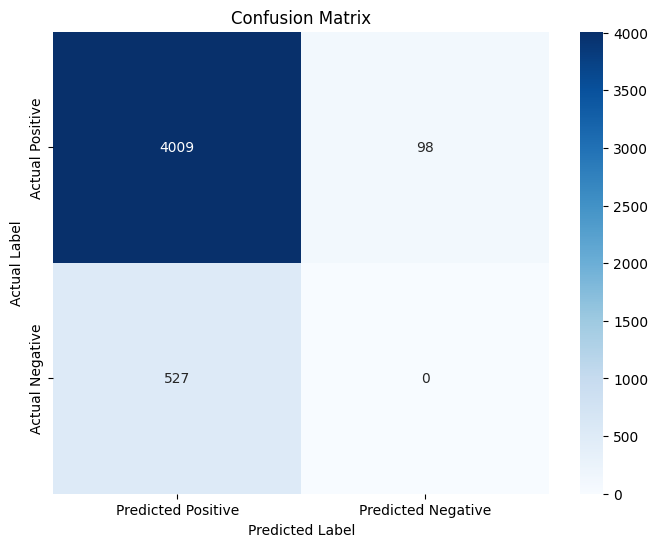

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Confusion matrix data
confusion_matrix = np.array([[4009, 98], [527, 0]])

# Labels for the axes
labels = ['Actual Positive', 'Actual Negative']
pred_labels = ['Predicted Positive', 'Predicted Negative']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()